Note: maybe cell about eliminating data with filtering
 import the data after eliminating outliers that likely aren't actual session (score < 50 or dartsFired < 10)


# 1 Computing Derived Data

This cell reads the filtered csv file, derives 4 metrics (grip_ratio, input_preference, score_per_throw, throws_per_s), renames movement columns to hand_movement, head_movement, yaw_range, and pitch_range. Finally it saves the data to a new csv file called `sessions_enriched.csv` and displays the first 5 rows.


In [ ]:
import pandas as pd
from pathlib import Path

# Loading raw data
df = pd.read_csv('sessions.csv')

# calculate derived columns
# input preference metrics
df["grip_ratio"] = df["grip_count"] / (df["grip_count"] + df["trigger_count"])
df["input_preference"] = pd.cut(
    df["grip_ratio"],
    bins=[-float("inf"), 0.30, 0.70, float("inf")],
    labels=["trigger-heavy", "mixed", "grip-heavy"]
)

# performance metrics
df['score_per_throw'] = df['score'] / df['dartsFired']
df['throws_per_s']    = df['dartsFired'] / 180.0 # session length = 180 s
df['controller_path'] = df['rightControllerMovement'] # rename for brevity

# movement metrics
df = df.rename(
    columns={
        "rightControllerMovement": "hand_movement",
        "headMovement": "head_movement",
        "lookAroundYawRange": "yaw_range",
        "lookAroundPitchRange": "pitch_range",
    }
)

# save the enriched DataFrame to a new CSV file
df.to_csv('sessions_enriched.csv', index=False)

print('Derived table saved: sessions_enriched.csv  (rows:', len(df), ')')

# quick preview to display the first 5 rows
df.head(5)


Derived table saved: sessions_enriched.csv  (rows: 151 )


,playerId,timestamp,score,dartsFired,balloonsPopped,head_movement,accuracy,leftControllerMovement,hand_movement,yaw_range,pitch_range,trigger_count,grip_count,grip_ratio,input_preference,score_per_throw,throws_per_s,controller_path
0,2f2b5eaf-497e-49bc-b2eb-0a51dfc2e3c9,2025-05-28T10:41:51.7812250Z,5495,243,182,11.421674,0.748971,1.845922,59.644508,359.779602,42.422947,285,26,0.083601,trigger-heavy,22.613169,1.350000,59.644508
1,d7fc102e-cc55-4e74-bc00-da3775ba5cbe,2025-06-01T10:44:03.2957750Z,450,49,20,3.685956,0.408163,0.019614,14.224772,259.007996,154.145599,71,7,0.089744,trigger-heavy,9.183673,0.272222,14.224772
2,447c0b19-a600-40c3-987f-6fa8c11a6803,2025-06-01T10:44:44.9141340Z,190,29,6,3.419049,0.206897,0.005383,17.287794,358.407959,68.629578,6,35,0.853659,grip-heavy,6.551724,0.161111,17.287794
3,f78e3fdd-31e4-416f-8dba-72615b6650f6,2025-06-01T10:48:49.7221210Z,2400,142,82,15.524384,0.577465,3.099314,48.392853,359.893066,140.702744,6,194,0.970000,grip-heavy,16.901408,0.788889,48.392853
4,073ec056-6872-40c6-b88a-437b268a0e50,2025-06-01T10:49:51.8161690Z,855,35,20,5.223118,0.571429,0.091024,13.797243,250.343506,82.410049,1,46,0.978723,grip-heavy,24.428571,0.194444,13.797243


# 2 Creating the Distance-ready table

This cell loads the previously generate csv file and creates a new DataFrame with winsorized and standardised data. In addition to that, we calculate a DevelopmentIndex to use as a proxy for age. Everything is then added together and saved to `sessions_dist.csv`

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
from scipy.stats import zscore

# loading the enriched data
df_dist = pd.read_csv(Path("sessions_enriched.csv"))

# selecting numberic features used in PCA and clustering
features = [
    "grip_ratio",
    "accuracy",
    "score_per_throw",
    "throws_per_s",
    "hand_movement",
    "head_movement",
    "yaw_range",
    "pitch_range",
]

# winsorise 1 % tails (per feature)
for col in features:
    lo, hi = np.percentile(df_dist[col], [1, 99])
    df_dist[col] = df_dist[col].clip(lo, hi)

# Z-scale those same colums
df_dist[features] = df_dist[features].apply(zscore)

# compute DevelopmntIndex
df_dist["DevelopmentIndex"] = (
    df_dist["grip_ratio"]      # already z-scaled
    + df_dist["hand_movement"]
    + df_dist["head_movement"]
    - df_dist["accuracy"]
)

# save the distance-ready table
df_dist.to_csv(Path("sessions_dist.csv"), index=False)
print("File written: sessions_dist.csv")

df_dist[features + ["DevelopmentIndex"]].describe().T

File written: sessions_dist.csv


,count,mean,std,min,25%,50%,75%,max
grip_ratio,151.0,-1.205805e-16,1.003328,-1.317284,-1.039430,-0.018990,1.116015,1.154275
accuracy,151.0,-1.646953e-16,1.003328,-1.812905,-0.738876,-0.002777,0.556349,2.295103
score_per_throw,151.0,-2.588070e-16,1.003328,-1.664861,-0.759574,-0.078365,0.628460,2.917870
throws_per_s,151.0,2.323381e-16,1.003328,-2.228222,-0.809055,0.197840,0.792463,1.537724
hand_movement,151.0,9.117063e-17,1.003328,-1.724511,-0.719386,-0.090252,0.644136,2.696640
head_movement,151.0,-7.058372e-17,1.003328,-1.462875,-0.729552,-0.232224,0.442250,3.109090
yaw_range,151.0,-9.653794e-16,1.003328,-6.438352,0.191659,0.197578,0.200192,0.202362
pitch_range,151.0,1.117575e-16,1.003328,-2.002879,-0.686853,0.032263,0.879001,1.788916
DevelopmentIndex,151.0,1.176395e-16,2.517209,-5.076376,-1.733764,-0.089454,1.460743,7.194705


# 3 Clustering and PCA

All of the following cells work directly on `sessions_dist.csv` created in Step 2.


## 3.1 Imports and loading data

Loading `sessions_dist.csv`

In [96]:
import pandas as pd
import numpy as np
import scipy.stats as ss
import scikit_posthocs as sp
from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler # added for safety
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# reading the distance-ready table
df = pd.read_csv(Path("sessions_dist.csv"))

# eight z-scaled features that feed PCA / clustering
features = [
    "grip_ratio", "accuracy", "score_per_throw", "throws_per_s",
    "hand_movement", "head_movement", "yaw_range", "pitch_range"
]
X = df[features].values # numpy array for scikit-learn

## 3.2 PCA scree plot

We plot the eigenvalues and the cumulative variance to decide how many PCs to keep for vizualization.

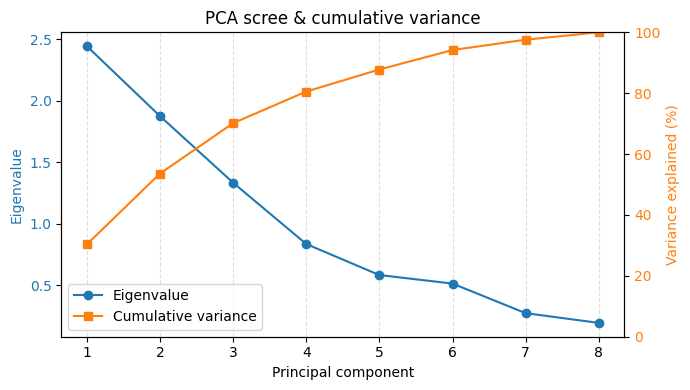

In [102]:
pca = PCA().fit(X)

eigvals = pca.explained_variance_
cumvariance  = np.cumsum(pca.explained_variance_ratio_) * 100  # %

components = np.arange(1, len(eigvals) + 1)

fig, ax1 = plt.subplots(figsize=(7,4))

# Eigenvalues on the left y-axis 
ax1.plot(components, eigvals, marker="o", label="Eigenvalue")
ax1.set_xlabel("Principal component")
ax1.set_ylabel("Eigenvalue", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")
ax1.grid(True, which="both", axis="x", linestyle="--", alpha=0.4)

# Cumulative variance on the right y-axis
ax2 = ax1.twinx()
ax2.plot(components, cumvariance, marker="s", linestyle="-",
         color="tab:orange", label="Cumulative variance")
ax2.set_ylabel("Variance explained (%)", color="tab:orange")
ax2.tick_params(axis="y", labelcolor="tab:orange")
ax2.set_ylim(0, 100)

# Combine legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc="lower left")

plt.title("PCA scree & cumulative variance")
plt.tight_layout()
plt.show()



Find which components to keep


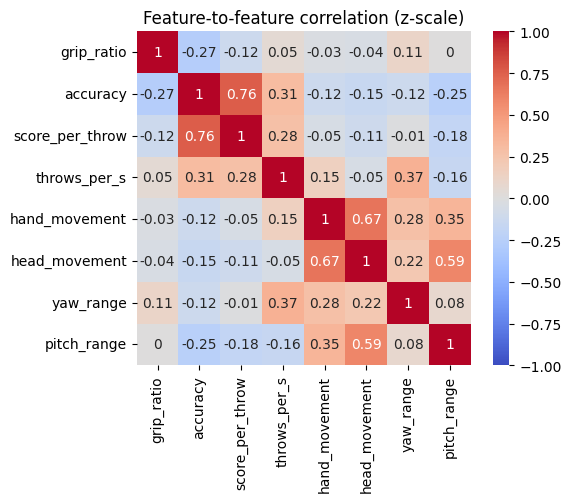

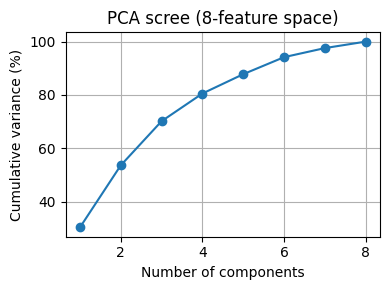

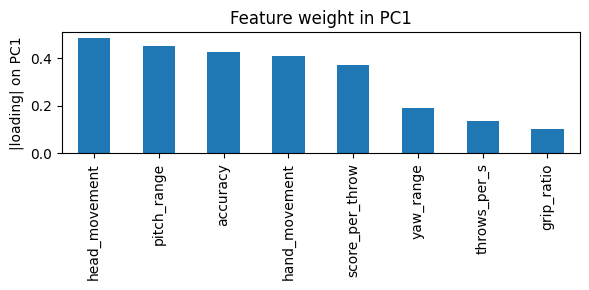

,Feature,Var.explained (PC1–PC3)
7,pitch_range,0.298
0,grip_ratio,0.329
4,hand_movement,0.330
2,score_per_throw,0.371
5,head_movement,0.389
6,yaw_range,0.421
1,accuracy,0.423
3,throws_per_s,0.439


In [ ]:
import seaborn as sns

# -------------------------------------------------------------
# 0. Select the eight z-scaled features you started with
features8 = [
    "grip_ratio", "accuracy", "score_per_throw", "throws_per_s",
    "hand_movement", "head_movement", "yaw_range", "pitch_range"
]
X8 = df[features8].values

# -------------------------------------------------------------
# 1. Pairwise correlation matrix  (Pearson; features are z-scaled)
corr = df[features8].corr(method="pearson").round(2)

plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1, square=True)
plt.title("Feature-to-feature correlation (z-scale)")
plt.tight_layout()
plt.show()

# -------------------------------------------------------------
# 2. PCA – explained variance and per-feature loading magnitude
pca = PCA().fit(X8)

# Scree plot
plt.figure(figsize=(4,3))
plt.plot(np.arange(1, len(pca.explained_variance_)+1),
         pca.explained_variance_ratio_.cumsum()*100, marker="o")
plt.xlabel("Number of components"); plt.ylabel("Cumulative variance (%)")
plt.title("PCA scree (8-feature space)"); plt.grid(True); plt.tight_layout()
plt.show()

# Contribution of each feature to the first principal component
loading_pc1 = pd.Series(pca.components_[0], index=features8).abs().round(3)
loading_pc1.sort_values(ascending=False).plot(kind="bar", figsize=(6,3))
plt.ylabel("|loading| on PC1"); plt.title("Feature weight in PC1"); plt.tight_layout()
plt.show()

# -------------------------------------------------------------
# 3. Quick numeric summary
low_var = pd.DataFrame({
    "Feature": features8,
    "Var.explained (PC1–PC3)": (pca.components_[:3]**2).sum(axis=0).round(3)
}).sort_values("Var.explained (PC1–PC3)")
display(low_var)

compare 5 feature vs 8 feature silhouette scores

In [ ]:

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

# 8-feature z-scaled matrix
features8 = ["grip_ratio","accuracy","score_per_throw","throws_per_s",
             "hand_movement","head_movement","yaw_range","pitch_range"]
X8 = df[features8].values
X4 = df[["accuracy","score_per_throw","throws_per_s","hand_movement"]].values


# PCA-influence ranking (first 3 PCs)
pca = PCA().fit(X8)
influence = (pca.components_[:3]**2).sum(axis=0)
top5_idxs  = np.argsort(-influence)[:5]
top5_feats = [features8[i] for i in top5_idxs]
print("Top-5 features by PCA influence:", top5_feats)

# Variant A: add grip_ratio to those top-5 (ensure no duplicate)
features6 = list(dict.fromkeys(["grip_ratio"] + top5_feats))
X6        = df[features6].values

# Variant B: ergonomic five-feature set
features5 = ["grip_ratio","accuracy","score_per_throw",
             "throws_per_s","hand_movement", "pitch_range"]
X5 = df[features5].values

def best_silhouette(X):
    s = []
    for k in range(2,7):
        km = KMeans(k, random_state=42).fit(X)
        s.append(silhouette_score(X, km.labels_))
    return max(s)

print("Silhouette 8-feature:", round(best_silhouette(X),3))
print("Silhouette 6-feature:", round(best_silhouette(X6),3))
print("Silhouette 5-feature:", round(best_silhouette(X5),3))
print("Silhouette 4-feature:", round(best_silhouette(X4),3))


Top-5 features by PCA influence: ['throws_per_s', 'accuracy', 'yaw_range', 'head_movement', 'score_per_throw']
Silhouette 8-feature: 0.2
Silhouette 6-feature: 0.264
Silhouette 5-feature: 0.249
Silhouette 4-feature: 0.289


In [ ]:
# 1. Build 5-feature matrix (drop yaw_range & pitch_range)
features5 = [
    "grip_ratio", "accuracy", "score_per_throw",
    "throws_per_s", "hand_movement"
]
X5 = df[features5].values

# 2. Re-run K-means with k = 4
from sklearn.cluster import KMeans
km5 = KMeans(n_clusters=4, random_state=42).fit(X5)
df["cluster_id"] = km5.labels_
df.to_csv("sessions_with_clusters.csv", index=False)
print("✔ cluster assignments (5-feature, k=4) saved")

# 3. Quick silhouette check
from sklearn.metrics import silhouette_score
print("Mean silhouette =", round(silhouette_score(X5, km5.labels_), 3))

✔ cluster assignments (5-feature, k=4) saved
Mean silhouette = 0.249


# 

## 3.3 Choosing k with silhoutte and elbow criteria

By applying sillhouette and elbow criteria we can pick an optimum value for k.

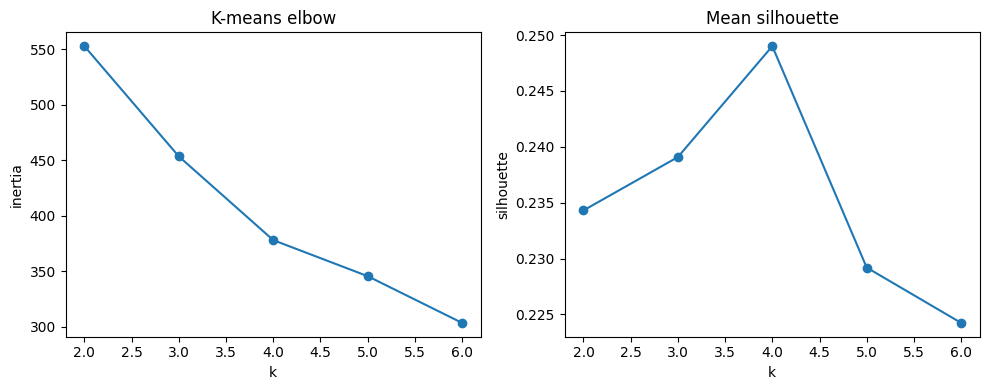

Suggested k by silhouette: 4


In [127]:
k_range = range(2, 7)        # try 2–6 clusters
sil_scores, inertias = [], []

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42).fit(X5)
    sil_scores.append(silhouette_score(X5, km.labels_))
    inertias.append(km.inertia_)         # within-cluster SSE

fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].plot(list(k_range), inertias, marker="o")
ax[0].set_title("K-means elbow")
ax[0].set_xlabel("k"); ax[0].set_ylabel("inertia")


ax[1].plot(list(k_range), sil_scores, marker="o")
ax[1].set_title("Mean silhouette")
ax[1].set_xlabel("k"); ax[1].set_ylabel("silhouette")

plt.tight_layout(); plt.show()

best_k = int(k_range[np.argmax(sil_scores)])
print(f"Suggested k by silhouette: {best_k}")

Comment: we can se an elbow forming at k = 4, hoever, sillhouete highest value is for k = 6.

## 3.4 K-means and GMM - pick the better silhouette

In [41]:
k_final = 4

# K-means
km = KMeans(n_clusters=k_final, random_state=42).fit(X5)
sil_km = silhouette_score(X5, km.labels_)

# GMM
gmm = GaussianMixture(n_components=k_final, covariance_type="full",
                      random_state=42, n_init=10).fit(X5)
gmm_labels = gmm.predict(X5)
sil_gmm = silhouette_score(X5, gmm_labels)

print(f"Silhouette  K-means: {sil_km:.3f}   |   GMM: {sil_gmm:.3f}")

if sil_gmm > sil_km:
    df["cluster_id"] = gmm_labels
    chosen = "GMM"
else:
    df["cluster_id"] = km.labels_
    chosen = "K-means"

print(f"Chosen model: {chosen}  (k = {k_final})")

Silhouette  K-means: 0.249   |   GMM: 0.124
Chosen model: K-means  (k = 4)


# 3.5 Save cluster lables table & quick centroid profile

In [42]:
out_name = Path("sessions_with_clusters.csv")
df.to_csv(out_name, index=False)
print(f"File written: {out_name}")

# simple centroid table for inspection
centroid = (
    df.groupby("cluster_id")[features]
      .mean()
      .round(2)
      .assign(n_sessions=df.groupby("cluster_id").size())
)
centroid

File written: sessions_with_clusters.csv


,grip_ratio,accuracy,score_per_throw,throws_per_s,hand_movement,head_movement,yaw_range,pitch_range,n_sessions
cluster_id,,,,,,,,,
0,1.01,0.43,0.57,0.60,-0.24,-0.35,0.19,-0.30,40
1,-0.20,-0.46,-0.55,-1.24,-1.03,-0.44,-0.77,0.03,28
2,-1.10,0.79,0.68,0.44,0.12,-0.06,0.14,-0.20,43
3,0.31,-0.95,-0.91,-0.20,0.84,0.72,0.20,0.49,40


## 3.6 Ploting clustering results

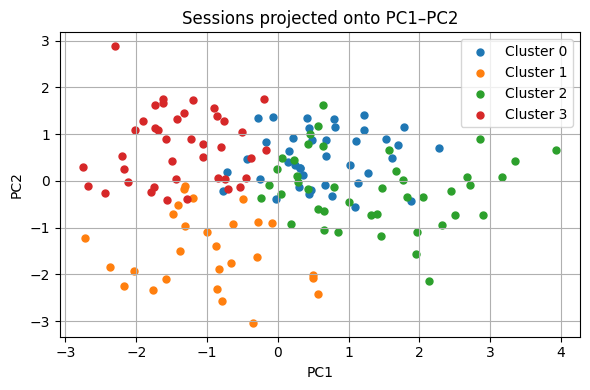

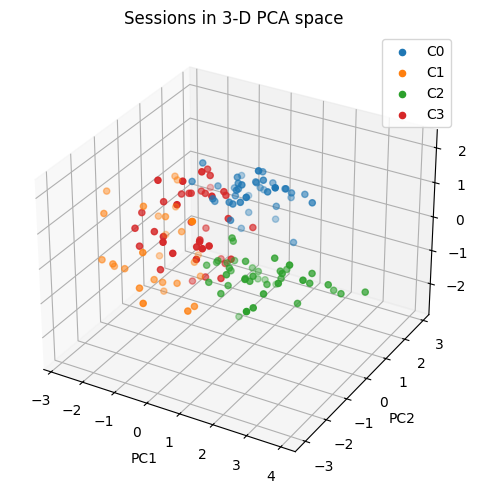

In [93]:
df = pd.read_csv(Path("sessions_with_clusters.csv"))

# 2. Feature matrix (z-scaled values from Step 2)
features = [
    "grip_ratio", "accuracy", "score_per_throw", "throws_per_s",
    "hand_movement", "head_movement", "yaw_range", "pitch_range"
]
X      = df[features].values
labels = df["cluster_id"].astype(int).values
k_final = labels.max() + 1

# 3. Fit PCA with three components (for plotting only)
pca = PCA(n_components=3, random_state=42).fit(X5)
pcs = pca.transform(X5)          # shape: (n_sessions, 3)

# ---------------------------------------------------------------
# 2-D scatter: PC1 vs PC2
plt.figure(figsize=(6, 4))
for c in range(k_final):
    idx = labels == c
    plt.scatter(pcs[idx, 0], pcs[idx, 1], label=f"Cluster {c}", s=25)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Sessions projected onto PC1–PC2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------------------------------------------------------------
# 3-D scatter: PC1, PC2, PC3 (rotate interactively in Jupyter)
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection="3d")
for c in range(k_final):
    idx = labels == c
    ax.scatter(pcs[idx, 0], pcs[idx, 1], pcs[idx, 2], label=f"C{c}", s=20)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("Sessions in 3-D PCA space")
ax.legend()
plt.tight_layout()
plt.show()

# 3.7 t-SNE visualization

             mean       min
cluster                    
0        0.346901  0.066135
1        0.222557 -0.016492
2        0.200525 -0.044632
3        0.221764  0.034616


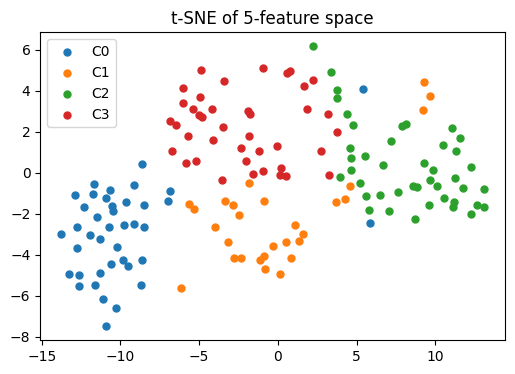

In [91]:
from sklearn.metrics import silhouette_samples
from sklearn.manifold import TSNE

# per-cluster silhouette
sil = silhouette_samples(X5, km5.labels_)
print(pd.DataFrame({'cluster': km5.labels_, 'sil': sil})
        .groupby('cluster').sil.describe()[['mean','min']])

# t-SNE scatter
ts = TSNE(n_components=2, perplexity=28, learning_rate='auto', random_state=42)
ts2d = ts.fit_transform(X5)
plt.figure(figsize=(6,4))
for c in range(k_final):
    idx = km5.labels_ == c
    plt.scatter(ts2d[idx,0], ts2d[idx,1], s=25, label=f"C{c}")
plt.legend(); plt.title("t-SNE of 5-feature space"); plt.show()

# 4. Non-parametric tests

## 4.1. Kruskal-Wallis test for cluster difference

In [31]:
df = pd.read_csv("sessions_with_clusters.csv")      # clusters already assigned

metrics = [
    "score", "accuracy", "score_per_throw", "throws_per_s",
    "grip_ratio", "hand_movement", "head_movement",
    "yaw_range", "pitch_range"
]

results = []

for m in metrics:
    groups = [df.loc[df.cluster_id == cid, m] for cid in sorted(df.cluster_id.unique())]
    H, p = ss.kruskal(*groups)
    results.append({"metric": m, "H": round(H, 3), "df": len(groups)-1, "p": p})

kruskal_df = pd.DataFrame(results).sort_values("p")
kruskal_df


,metric,H,df,p
0,score,103.556,3,2.671540e-22
4,grip_ratio,92.547,3,6.216086e-20
2,score_per_throw,84.762,3,2.918557e-18
1,accuracy,80.876,3,1.991578e-17
5,hand_movement,66.524,3,2.367074e-14
3,throws_per_s,60.805,3,3.956666e-13
6,head_movement,28.802,3,2.464965e-06
8,pitch_range,14.951,3,1.859021e-03
7,yaw_range,11.153,3,1.092864e-02


## 